# MISSION - Evaluation

## (0.1) Imports

In [113]:
import pandas as pd
import pm4py
import numpy as np
from pm4py.util import constants
from IPython.display import display
from IPython.display import Image
from pm4py.algo.filtering.dfg import dfg_filtering
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.conformance.tokenreplay.diagnostics import root_cause_analysis
from pm4py.visualization.decisiontree import visualizer as dt_vis
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.conformance import alignments as conformance_alignments
from pm4py.algo.discovery.log_skeleton import algorithm as lsk_discovery
from pm4py.algo.conformance.log_skeleton import algorithm as lsk_conformance
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics
from pm4py.algo.organizational_mining.sna import util
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
from pm4py.statistics.traces.generic.log import case_arrival
from pm4py.algo.organizational_mining.local_diagnostics import algorithm as local_diagnostics
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.algo.discovery.temporal_profile import algorithm as temporal_profile_discovery
from pm4py.algo.conformance.temporal_profile import algorithm as temporal_profile_conformance
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.visualization.graphs import visualizer as graphs_visualizer
from pm4py.statistics.variants.log import get as variants_module
from pm4py.algo.simulation.playout.petri_net import algorithm as simulator
from pm4py.algo.evaluation.earth_mover_distance import algorithm as emd_evaluator
from pm4py.algo.analysis.woflan import algorithm as woflan
import seaborn as sns

##  (0.2) User Definitions

In [114]:
# User definitions
filename = 'resources/flows.csv'
filename_malicious_DoS = 'resources/flows-malicious-DoS.csv'
filename_malicious_sidechannel = 'resources/flows-malicious-sidechannel.csv'
mqtt_brokers = ["192.168.2.171:1883"]
node_red = "192.168.2.172:58405"
ip_filter = ["10.10.2.14"]

## (0.3) Mappings

In [115]:
control_types = {1: "connect", 3: "publish", 8: "subscribe", 10: "unsubscribe", 12: "ping", 14: "disconnect"}
db_updates = []
client_ids_mapping = {}
for broker_key in mqtt_brokers:
    client_ids_mapping[broker_key] = "MQTT Broker"

## (1.0) Import CSV

In [116]:
df_flows = pd.read_csv(filename, nrows=file_lines)
df_flows.head()

,_id,sourceIPv4Address,sourceTransportPort,destinationIPv4Address,destinationTransportPort,protocol,flowStartNanoseconds,flowEndNanoseconds,flowDurationMicroseconds,mqttTopic,mqttPacketId,mqttQoS,mqttControlType,mqttSrcClientId,mqttDstClientId,mqttCorrelationData
0,632b11105cbea7a3bc1db846,192.168.2.172,54097,192.168.2.171,1883,6,"[1663766799,4186858496]","[1663766799,4187292672]",0,NaN,0,0,1,livingroom-sensor-temperature,"Unknown client, probably a broker.",NaN
1,632b11105cbea7a3bc1db847,192.168.2.172,48535,192.168.2.171,1883,6,"[1663766799,4194340864]","[1663766799,4194603008]",0,NaN,0,0,1,kitchen-sensor-temperature,"Unknown client, probably a broker.",NaN
2,632b11105cbea7a3bc1db848,192.168.2.172,54097,192.168.2.171,1883,6,"[1663766799,4193241088]","[1663766799,4195409920]",1,mind2/livingroom-sensor-temperature,1,2,3,livingroom-sensor-temperature,"Unknown client, probably a broker.",06857822-39b1-11ed-a47e-3be7a6e67cf0
3,632b11105cbea7a3bc1db849,192.168.2.172,38513,192.168.2.171,1883,6,"[1663766799,4202084352]","[1663766799,4202526720]",0,NaN,0,0,1,bathroom-sensor-temperature,"Unknown client, probably a broker.",NaN
4,632b11105cbea7a3bc1db84a,192.168.2.172,48535,192.168.2.171,1883,6,"[1663766799,4200988672]","[1663766799,4203681792]",1,mission/kitchen-sensor-temperature,1,2,3,kitchen-sensor-temperature,"Unknown client, probably a broker.",0685c91c-39b1-11ed-a47e-3be7a6e67cf0


## (2.0) Prerequisites

### (2.1) Data Cleaning & Preprocessing

In [117]:
def preprocessing(df_flows):
    for index, flow in df_flows.iterrows():  

        # check if row has a client identifier
        if 'mqttSrcClientId' in flow:
            src_key = f"{flow['sourceIPv4Address']}:{flow['sourceTransportPort']}"
            dst_key = f"{flow['destinationIPv4Address']}:{flow['destinationTransportPort']}"

            # check if source or destination is a MQTT broker's address
            if src_key in mqtt_brokers and "MQTT Broker" not in df_flows.loc[index,'mqttSrcClientId']:
                df_flows.loc[index,'mqttSrcClientId'] = client_ids_mapping[src_key]
            if dst_key in mqtt_brokers and "MQTT Broker" not in df_flows.loc[index,'mqttDstClientId']:
                df_flows.loc[index,'mqttDstClientId'] = client_ids_mapping[dst_key]

            # check if client identifier is unknown
            if "Unknown" in df_flows.loc[index,'mqttSrcClientId']:
                df_flows.loc[index,'mqttSrcClientId'] = src_key
            if "Unknown" in df_flows.loc[index,'mqttDstClientId']:
                df_flows.loc[index,'mqttDstClientId'] = dst_key

            # check if client has already been mapped
            if src_key not in client_ids_mapping:
                client_ids_mapping[src_key] = df_flows.loc[index,'mqttSrcClientId']
            if dst_key not in client_ids_mapping:
                client_ids_mapping[dst_key] = df_flows.loc[index,'mqttDstClientId']
            
            if src_key == node_red:
                df_flows.loc[index,'mqttSrcClientId'] = "Node-RED"

        # flow has not a client identifier
        else: 
            src_key = f"{flow['sourceIPv4Address']}:{flow['sourceTransportPort']}"
            dst_key = f"{flow['destinationIPv4Address']}:{flow['destinationTransportPort']}"

            if src_key in client_ids_mapping:
                df_flows.loc[index,'mqttSrcClientId'] = client_ids_mapping[src_key]
            else:
                df_flows.loc[index,'mqttSrcClientId'] = src_key
            if dst_key in client_ids_mapping:
                df_flows.loc[index,'mqttDstClientId'] = client_ids_mapping[dst_key]
            else:
                df_flows.loc[index,'mqttDstClientId'] = dst_key

            if src_key == node_red:
                df_flows.loc[index,'mqttSrcClientId'] = "Node-RED"

        # fix timestamp array received from MongoDB
        flow['flowStartNanoseconds'] = flow['flowStartNanoseconds'][1:-1]
        flow['flowEndNanoseconds'] = flow['flowEndNanoseconds'][1:-1]
        flow['flowStartNanoseconds'] = flow['flowStartNanoseconds'].split(",")
        flow['flowEndNanoseconds'] = flow['flowEndNanoseconds'].split(",")
        flow['flowStartNanoseconds'] = float(flow['flowStartNanoseconds'][0] + "." + flow['flowStartNanoseconds'][1])
        flow['flowEndNanoseconds'] = float(flow['flowEndNanoseconds'][0] + "." + flow['flowEndNanoseconds'][1])
        df_flows.loc[index,'flowStartNanoseconds'] = pd.Timestamp.fromtimestamp(flow['flowStartNanoseconds'])
        df_flows.loc[index,'flowEndNanoseconds'] = pd.Timestamp.fromtimestamp(flow['flowEndNanoseconds'])

    df_flows.fillna("no correlation",inplace=True)
    df_flows.sort_values(by=['flowStartNanoseconds'])
    return df_flows

df_flows = preprocessing(df_flows)
df_flows.head()

,_id,sourceIPv4Address,sourceTransportPort,destinationIPv4Address,destinationTransportPort,protocol,flowStartNanoseconds,flowEndNanoseconds,flowDurationMicroseconds,mqttTopic,mqttPacketId,mqttQoS,mqttControlType,mqttSrcClientId,mqttDstClientId,mqttCorrelationData
0,632b11105cbea7a3bc1db846,192.168.2.172,54097,192.168.2.171,1883,6,2022-09-21 15:26:39.418686,2022-09-21 15:26:39.418729,0,no correlation,0,0,1,livingroom-sensor-temperature,MQTT Broker,no correlation
1,632b11105cbea7a3bc1db847,192.168.2.172,48535,192.168.2.171,1883,6,2022-09-21 15:26:39.419434,2022-09-21 15:26:39.419460,0,no correlation,0,0,1,kitchen-sensor-temperature,MQTT Broker,no correlation
2,632b11105cbea7a3bc1db848,192.168.2.172,54097,192.168.2.171,1883,6,2022-09-21 15:26:39.419324,2022-09-21 15:26:39.419541,1,mind2/livingroom-sensor-temperature,1,2,3,livingroom-sensor-temperature,MQTT Broker,06857822-39b1-11ed-a47e-3be7a6e67cf0
3,632b11105cbea7a3bc1db849,192.168.2.172,38513,192.168.2.171,1883,6,2022-09-21 15:26:39.420208,2022-09-21 15:26:39.420253,0,no correlation,0,0,1,bathroom-sensor-temperature,MQTT Broker,no correlation
4,632b11105cbea7a3bc1db84a,192.168.2.172,48535,192.168.2.171,1883,6,2022-09-21 15:26:39.420099,2022-09-21 15:26:39.420368,1,mission/kitchen-sensor-temperature,1,2,3,kitchen-sensor-temperature,MQTT Broker,0685c91c-39b1-11ed-a47e-3be7a6e67cf0


### (2.2)  Event Log Conversion

In [118]:
def event_log_conversion(df_flows):
    event_log = []

    # Consider only publish flows
    for index, flow in df_flows.iterrows():
        if int(flow['mqttControlType']) == 3 and flow['mqttCorrelationData'] != "no correlation":
            # Create activity string
            activity = f"{flow['mqttSrcClientId']} \u2192 \n{flow['mqttTopic']}"

            # Append event data to the event log list
            event_log.append([
                flow['flowStartNanoseconds'],  # Time
                flow['mqttCorrelationData'],  # Case concept name
                flow['mqttSrcClientId'],  # Org resource
                activity  # Concept name
            ])

    # Convert event log list to DataFrame
    df_event_log = pd.DataFrame(event_log, columns=['time:timestamp', 'case:concept:name', 'org:resource', 'concept:name'])

    # Convert DataFrame to PM4Py event log format and return both formats
    return pm4py.convert_to_event_log(df_event_log), df_event_log

In [119]:
event_log, df_event_log = event_log_conversion(df_flows)
df_event_log.head()

,time:timestamp,case:concept:name,org:resource,concept:name
0,2022-09-21 15:26:39.419324,06857822-39b1-11ed-a47e-3be7a6e67cf0,livingroom-sensor-temperature,livingroom-sensor-temperature → \nmind2/living...
1,2022-09-21 15:26:39.420099,0685c91c-39b1-11ed-a47e-3be7a6e67cf0,kitchen-sensor-temperature,kitchen-sensor-temperature → \nmission/kitchen...
2,2022-09-21 15:26:39.420679,0685ffd6-39b1-11ed-a47e-3be7a6e67cf0,bathroom-sensor-temperature,bathroom-sensor-temperature → \nmission/bathro...
3,2022-09-21 15:26:39.422263,06868e1a-39b1-11ed-a47e-3be7a6e67cf0,garden1-sensor-temperature,garden1-sensor-temperature → \nmission/garden1...
4,2022-09-21 15:26:39.422987,0686c8bc-39b1-11ed-a47e-3be7a6e67cf0,garden2-sensor-temperature,garden2-sensor-temperature → \nmission/garden2...


## (3.0) Process Mining

###  (3.1) Directly Follows Graphs

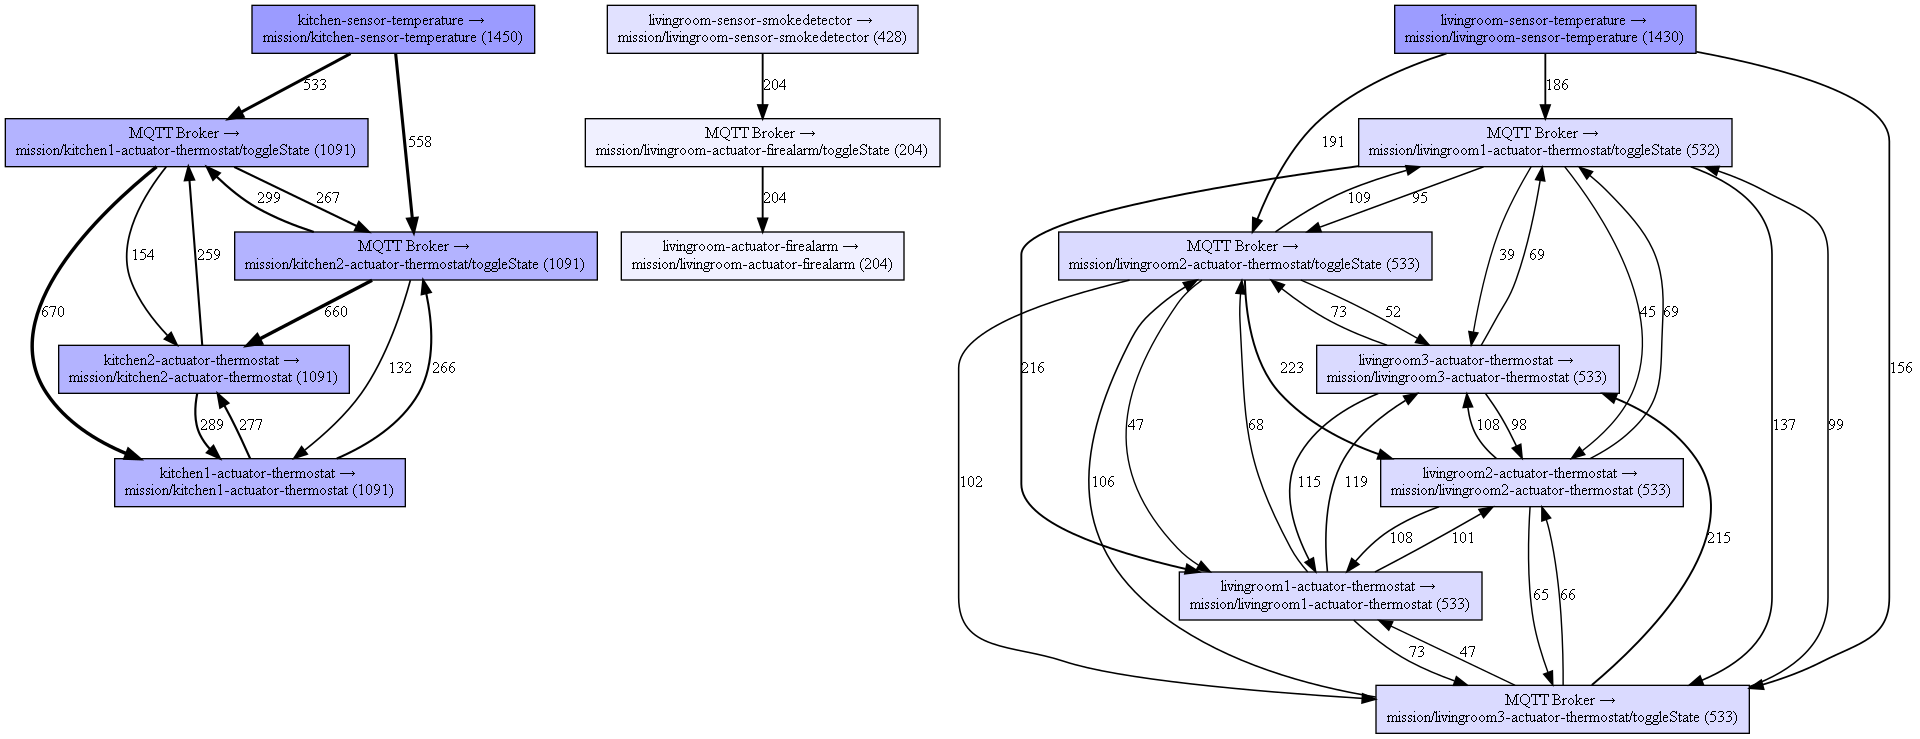

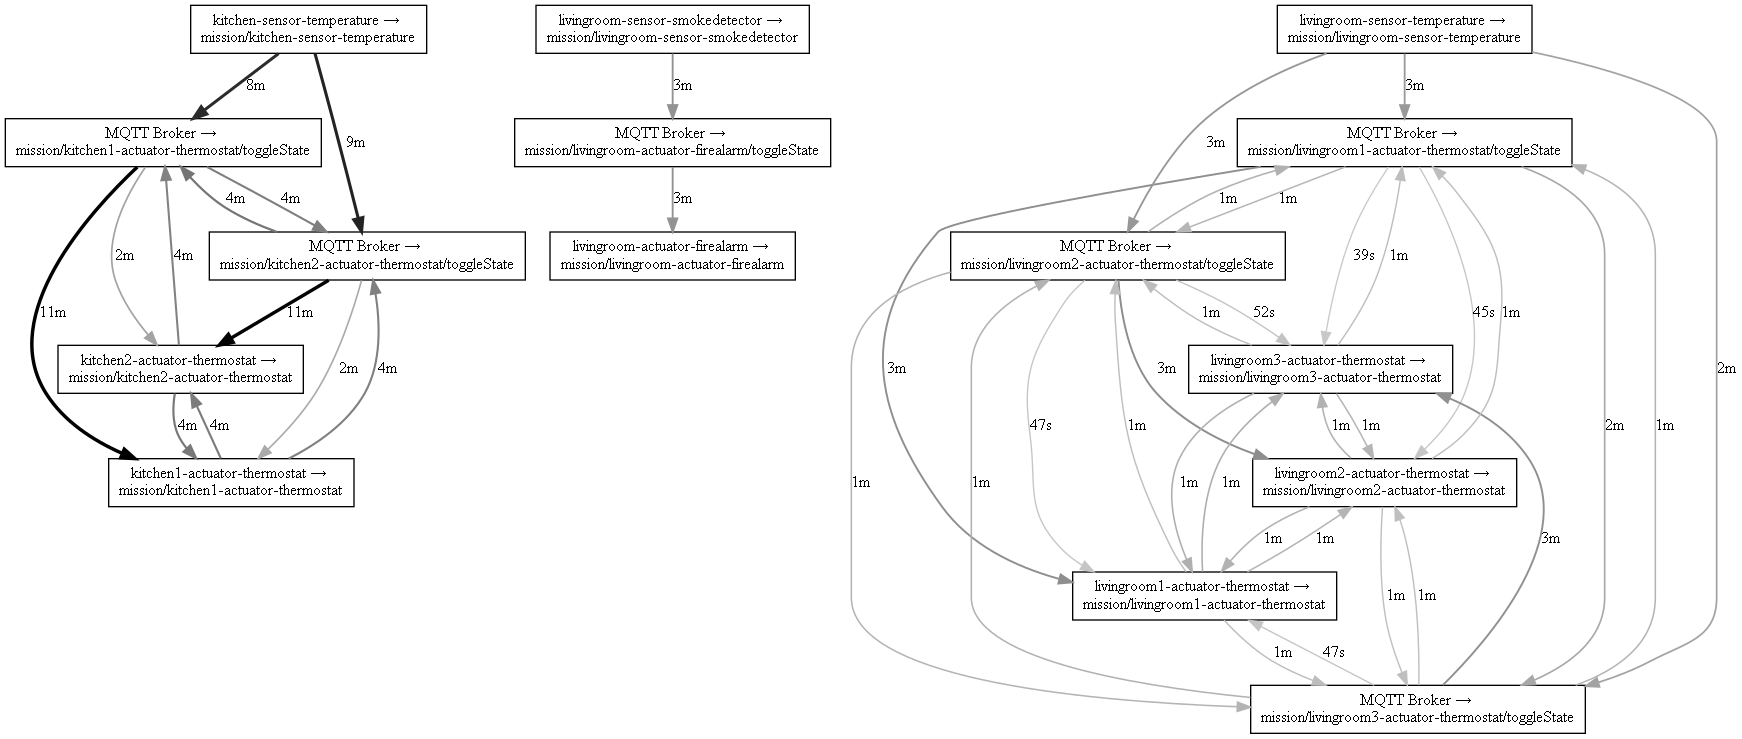

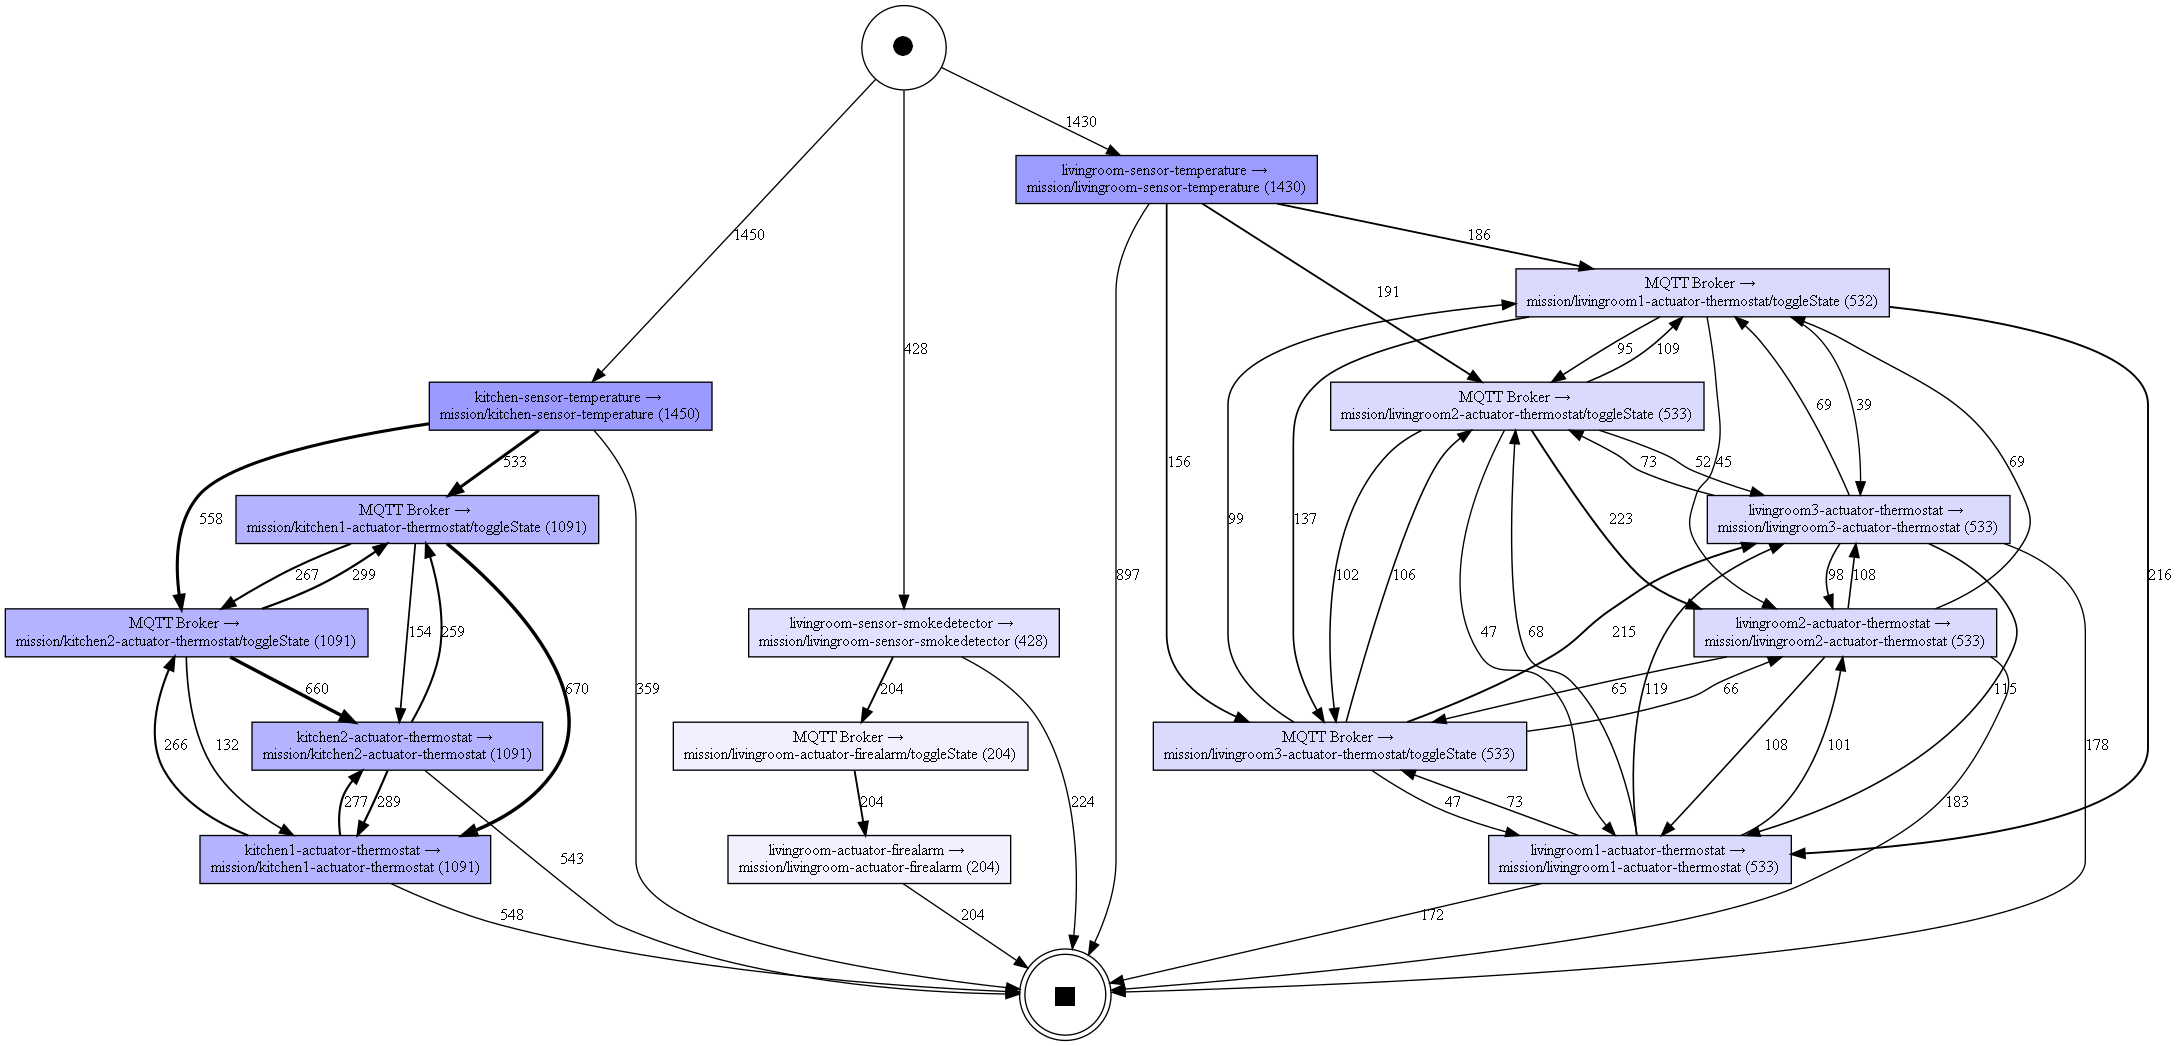

In [120]:
_df, _sa, _ea = pm4py.discover_directly_follows_graph(event_log)

# Filter the directly follows graph based on activities percentage
activities_count = pm4py.get_event_attribute_values(event_log, "concept:name")
_df, _sa, _ea, activities_count = dfg_filtering.filter_dfg_on_activities_percentage(_df, _sa, _ea, activities_count, 1)

# Generate visualizations for performance and frequency variants
gviz_perf = dfg_visualizer.apply(_df, variant=dfg_visualizer.Variants.PERFORMANCE,
                                 activities_count=activities_count, parameters={"format": "png"})
gviz_freq = dfg_visualizer.apply(_df, variant=dfg_visualizer.Variants.FREQUENCY,
                                 activities_count=activities_count, parameters={"format": "png"})
gviz_freq2 = dfg_visualizer.apply(_df, variant=dfg_visualizer.Variants.FREQUENCY,
                                  activities_count=activities_count, parameters={"format": "svg"})

# Save and display the visualizations
file_lines = len(event_log)
pn_visualizer.save(gviz_freq, f"resources/dfg_flows_{file_lines}.pdf")
dfg_visualizer.view(gviz_freq)
dfg_visualizer.view(gviz_perf)
pm4py.view_dfg(_df, _sa, _ea, format="png")

###  (3.2) Inductive Miner


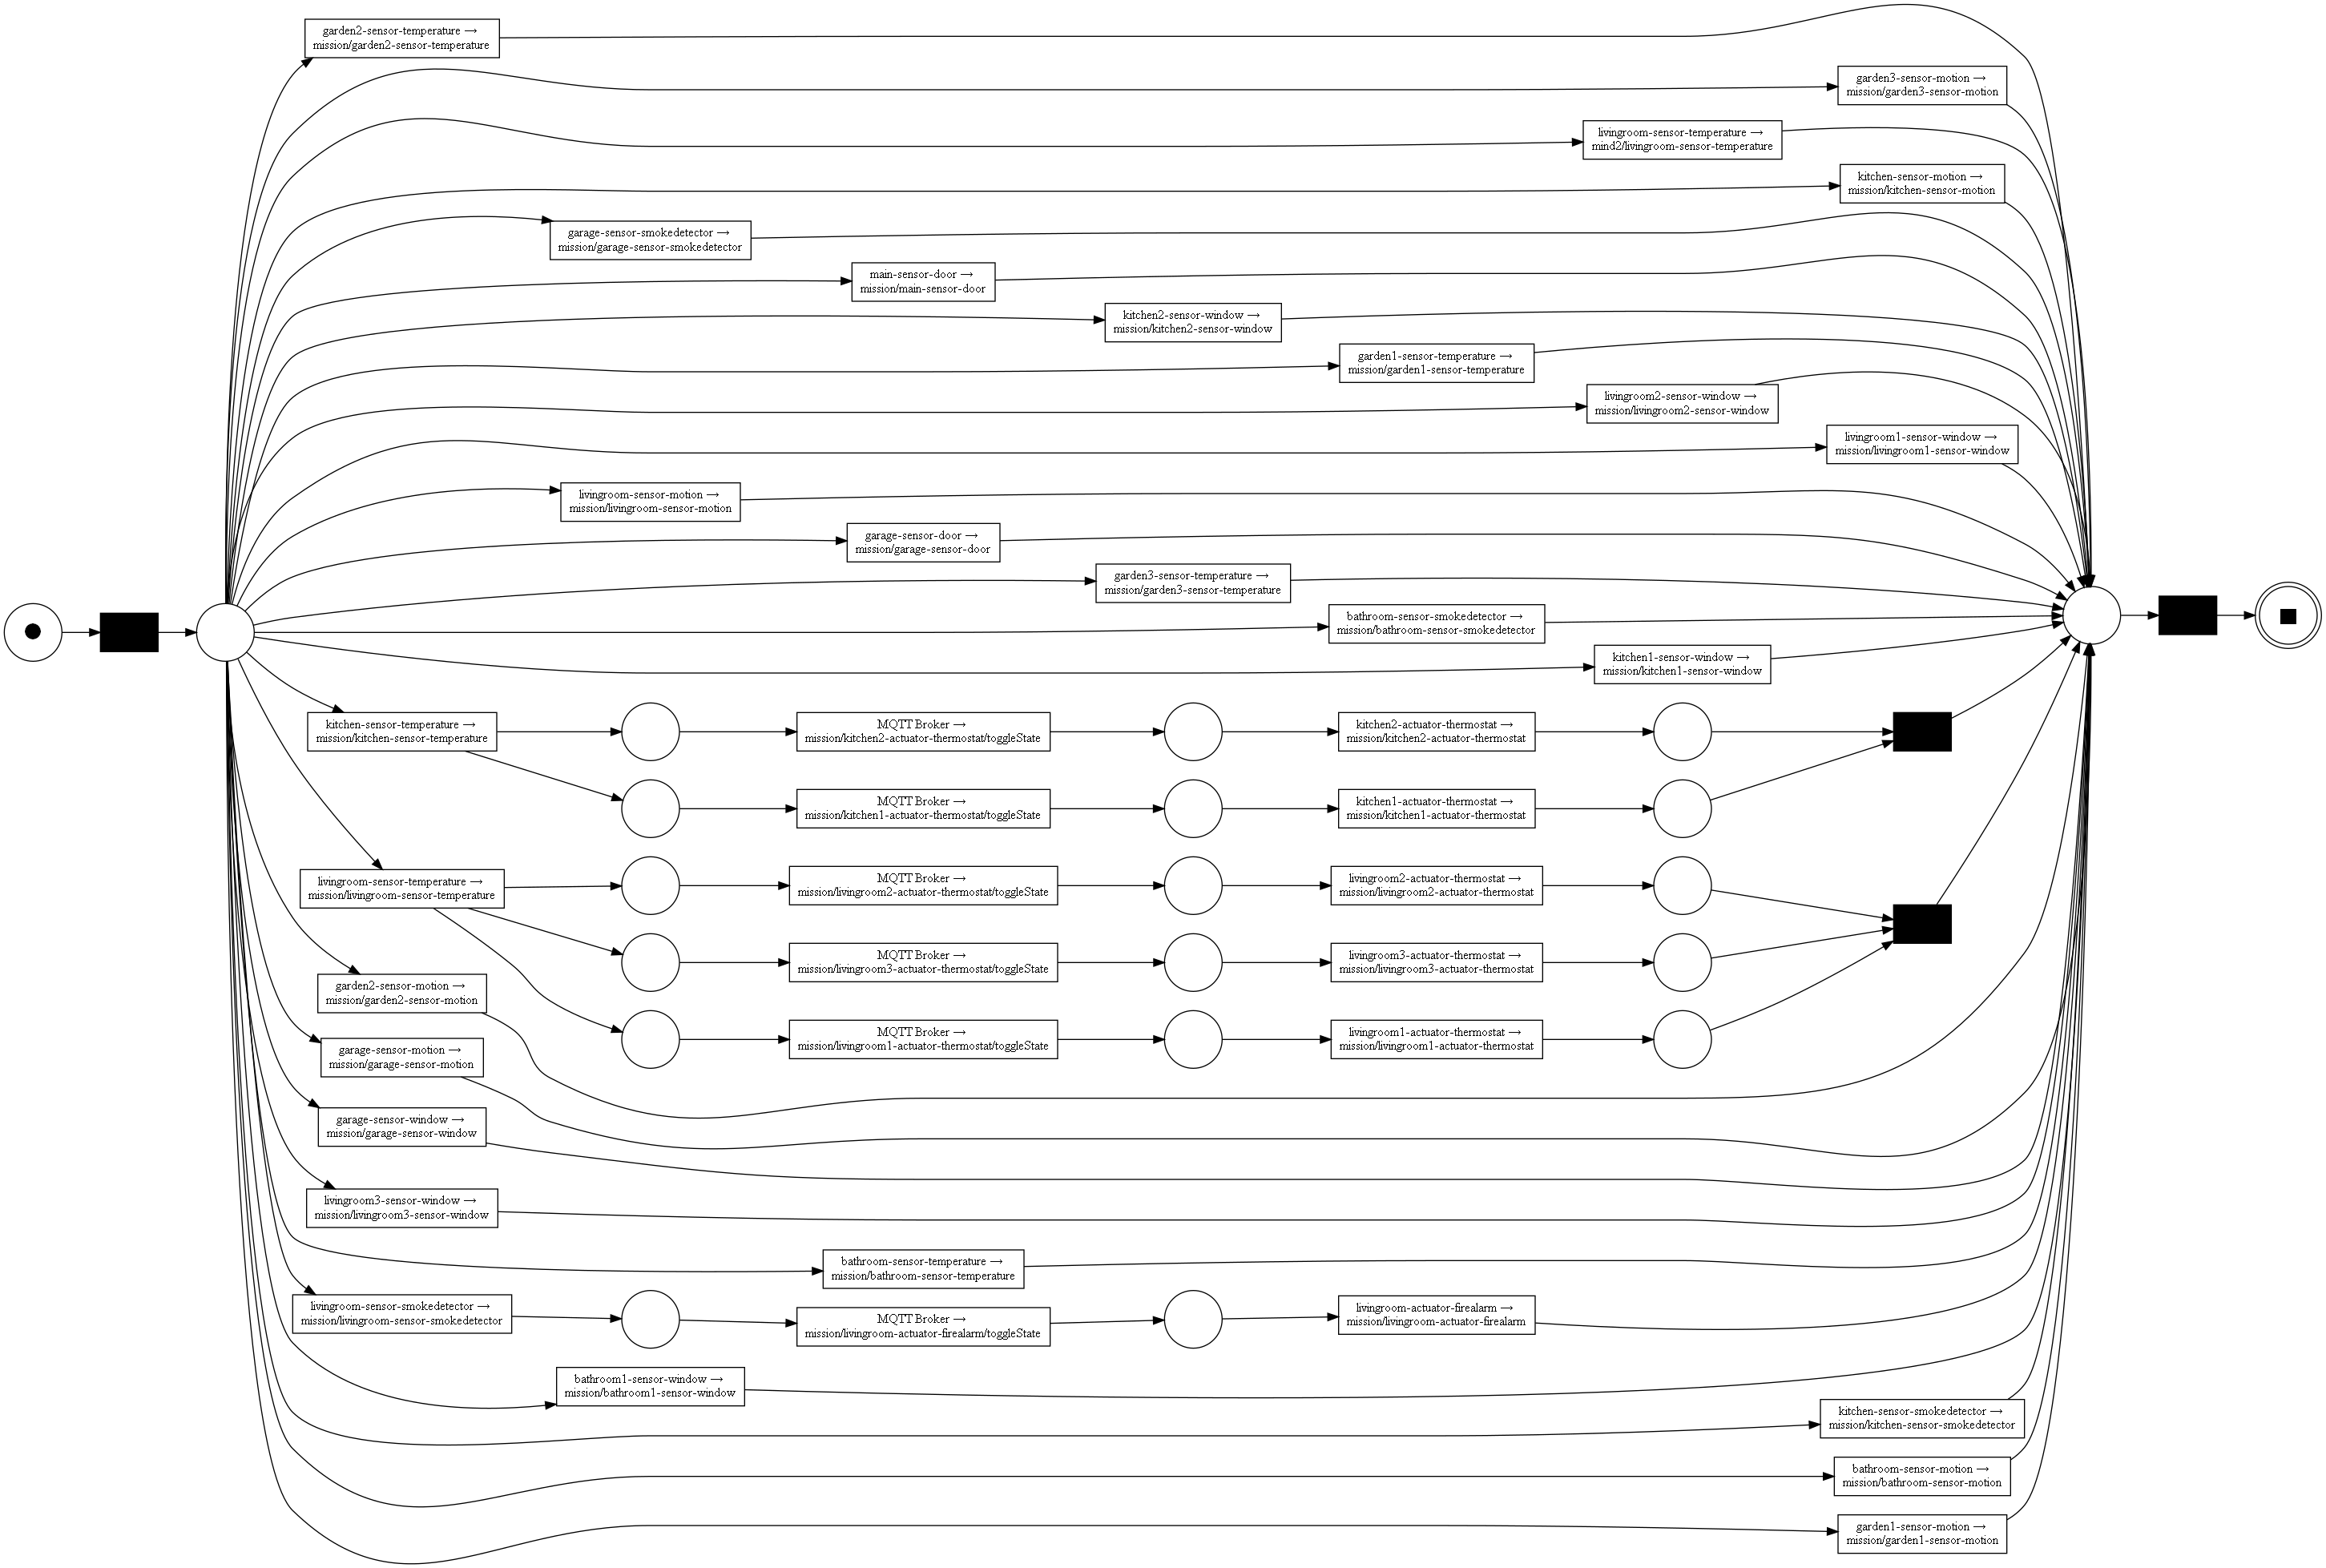

In [121]:
# Discover Petri net using the inductive miner algorithm
im_net, im_im, im_fm = pm4py.discover_petri_net_inductive(event_log, noise_threshold=0.9)

# Generate the visualization of the Petri net
viz_variant = pm4py.visualization.petri_net.visualizer.Variants.FREQUENCY
viz_parameters = {"format": "png"}
gviz = pm4py.visualization.petri_net.visualizer.apply(im_net, im_im, im_fm, variant=viz_variant, parameters=viz_parameters)

# View the Petri net visualization
pm4py.visualization.petri_net.visualizer.view(gviz)

###  (3.3) Heuristic Miner


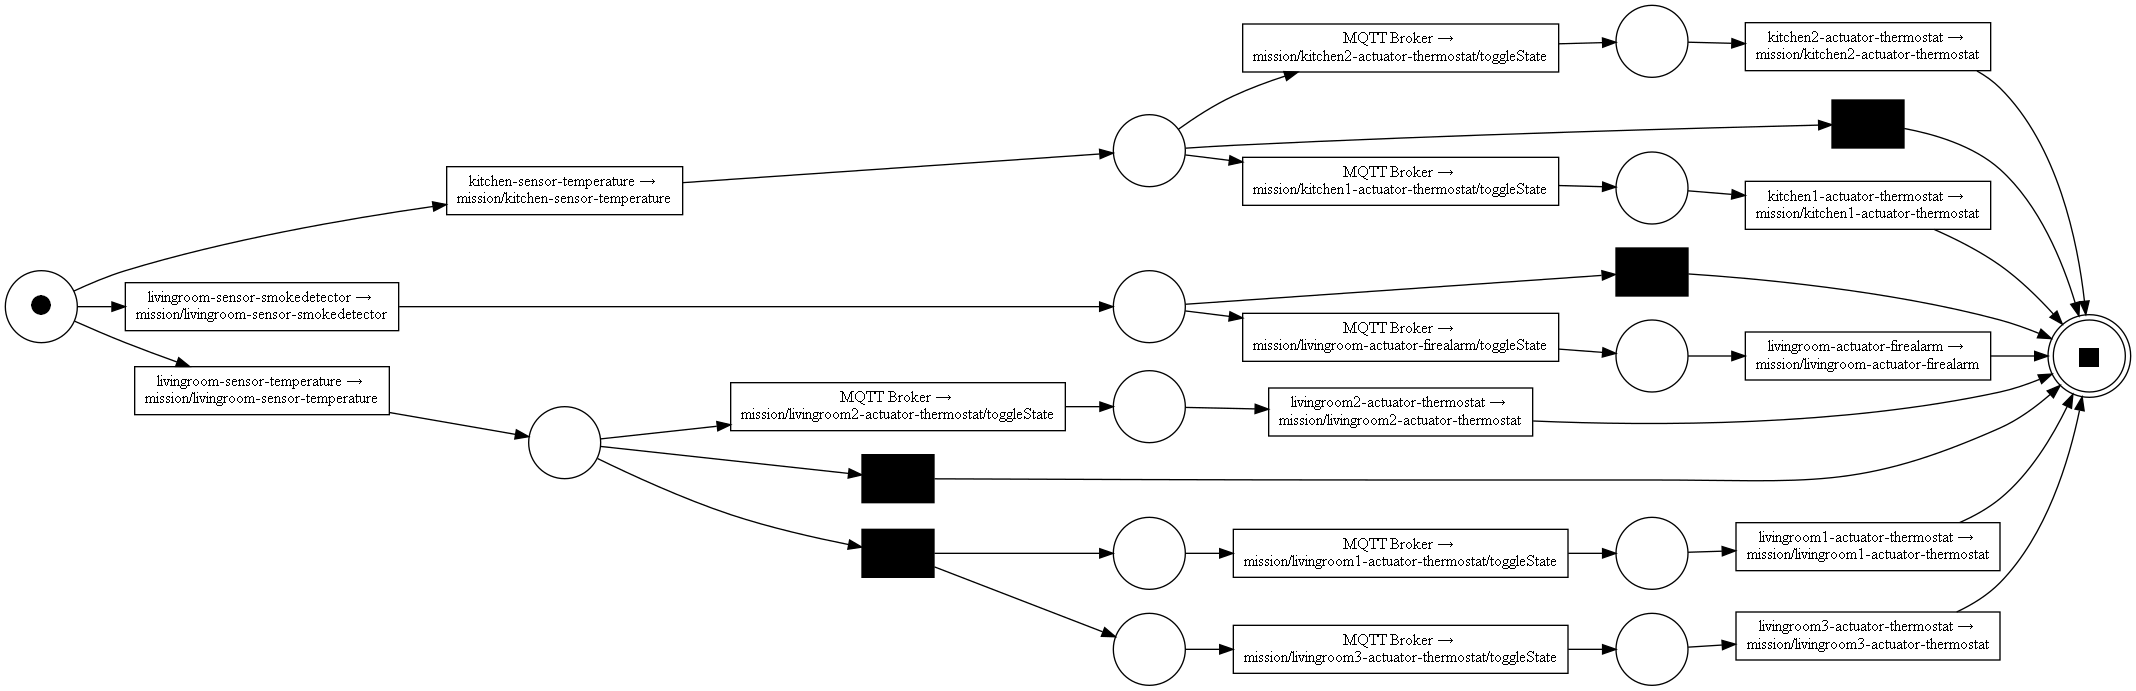

In [122]:
# Discover Petri net using the heuristics miner algorithm
hm_net, hm_im, hm_fm = pm4py.discover_petri_net_heuristics(event_log, dependency_threshold=0.9)

# Generate the visualization of the Petri net
viz_variant = pm4py.visualization.petri_net.visualizer.Variants.FREQUENCY
viz_parameters = {"format": "png"}
gviz = pm4py.visualization.petri_net.visualizer.apply(hm_net, hm_im, hm_fm, variant=viz_variant, parameters=viz_parameters)

# View the Petri net visualization
pm4py.visualization.petri_net.visualizer.view(gviz)

###  (3.4) Alpha Miner

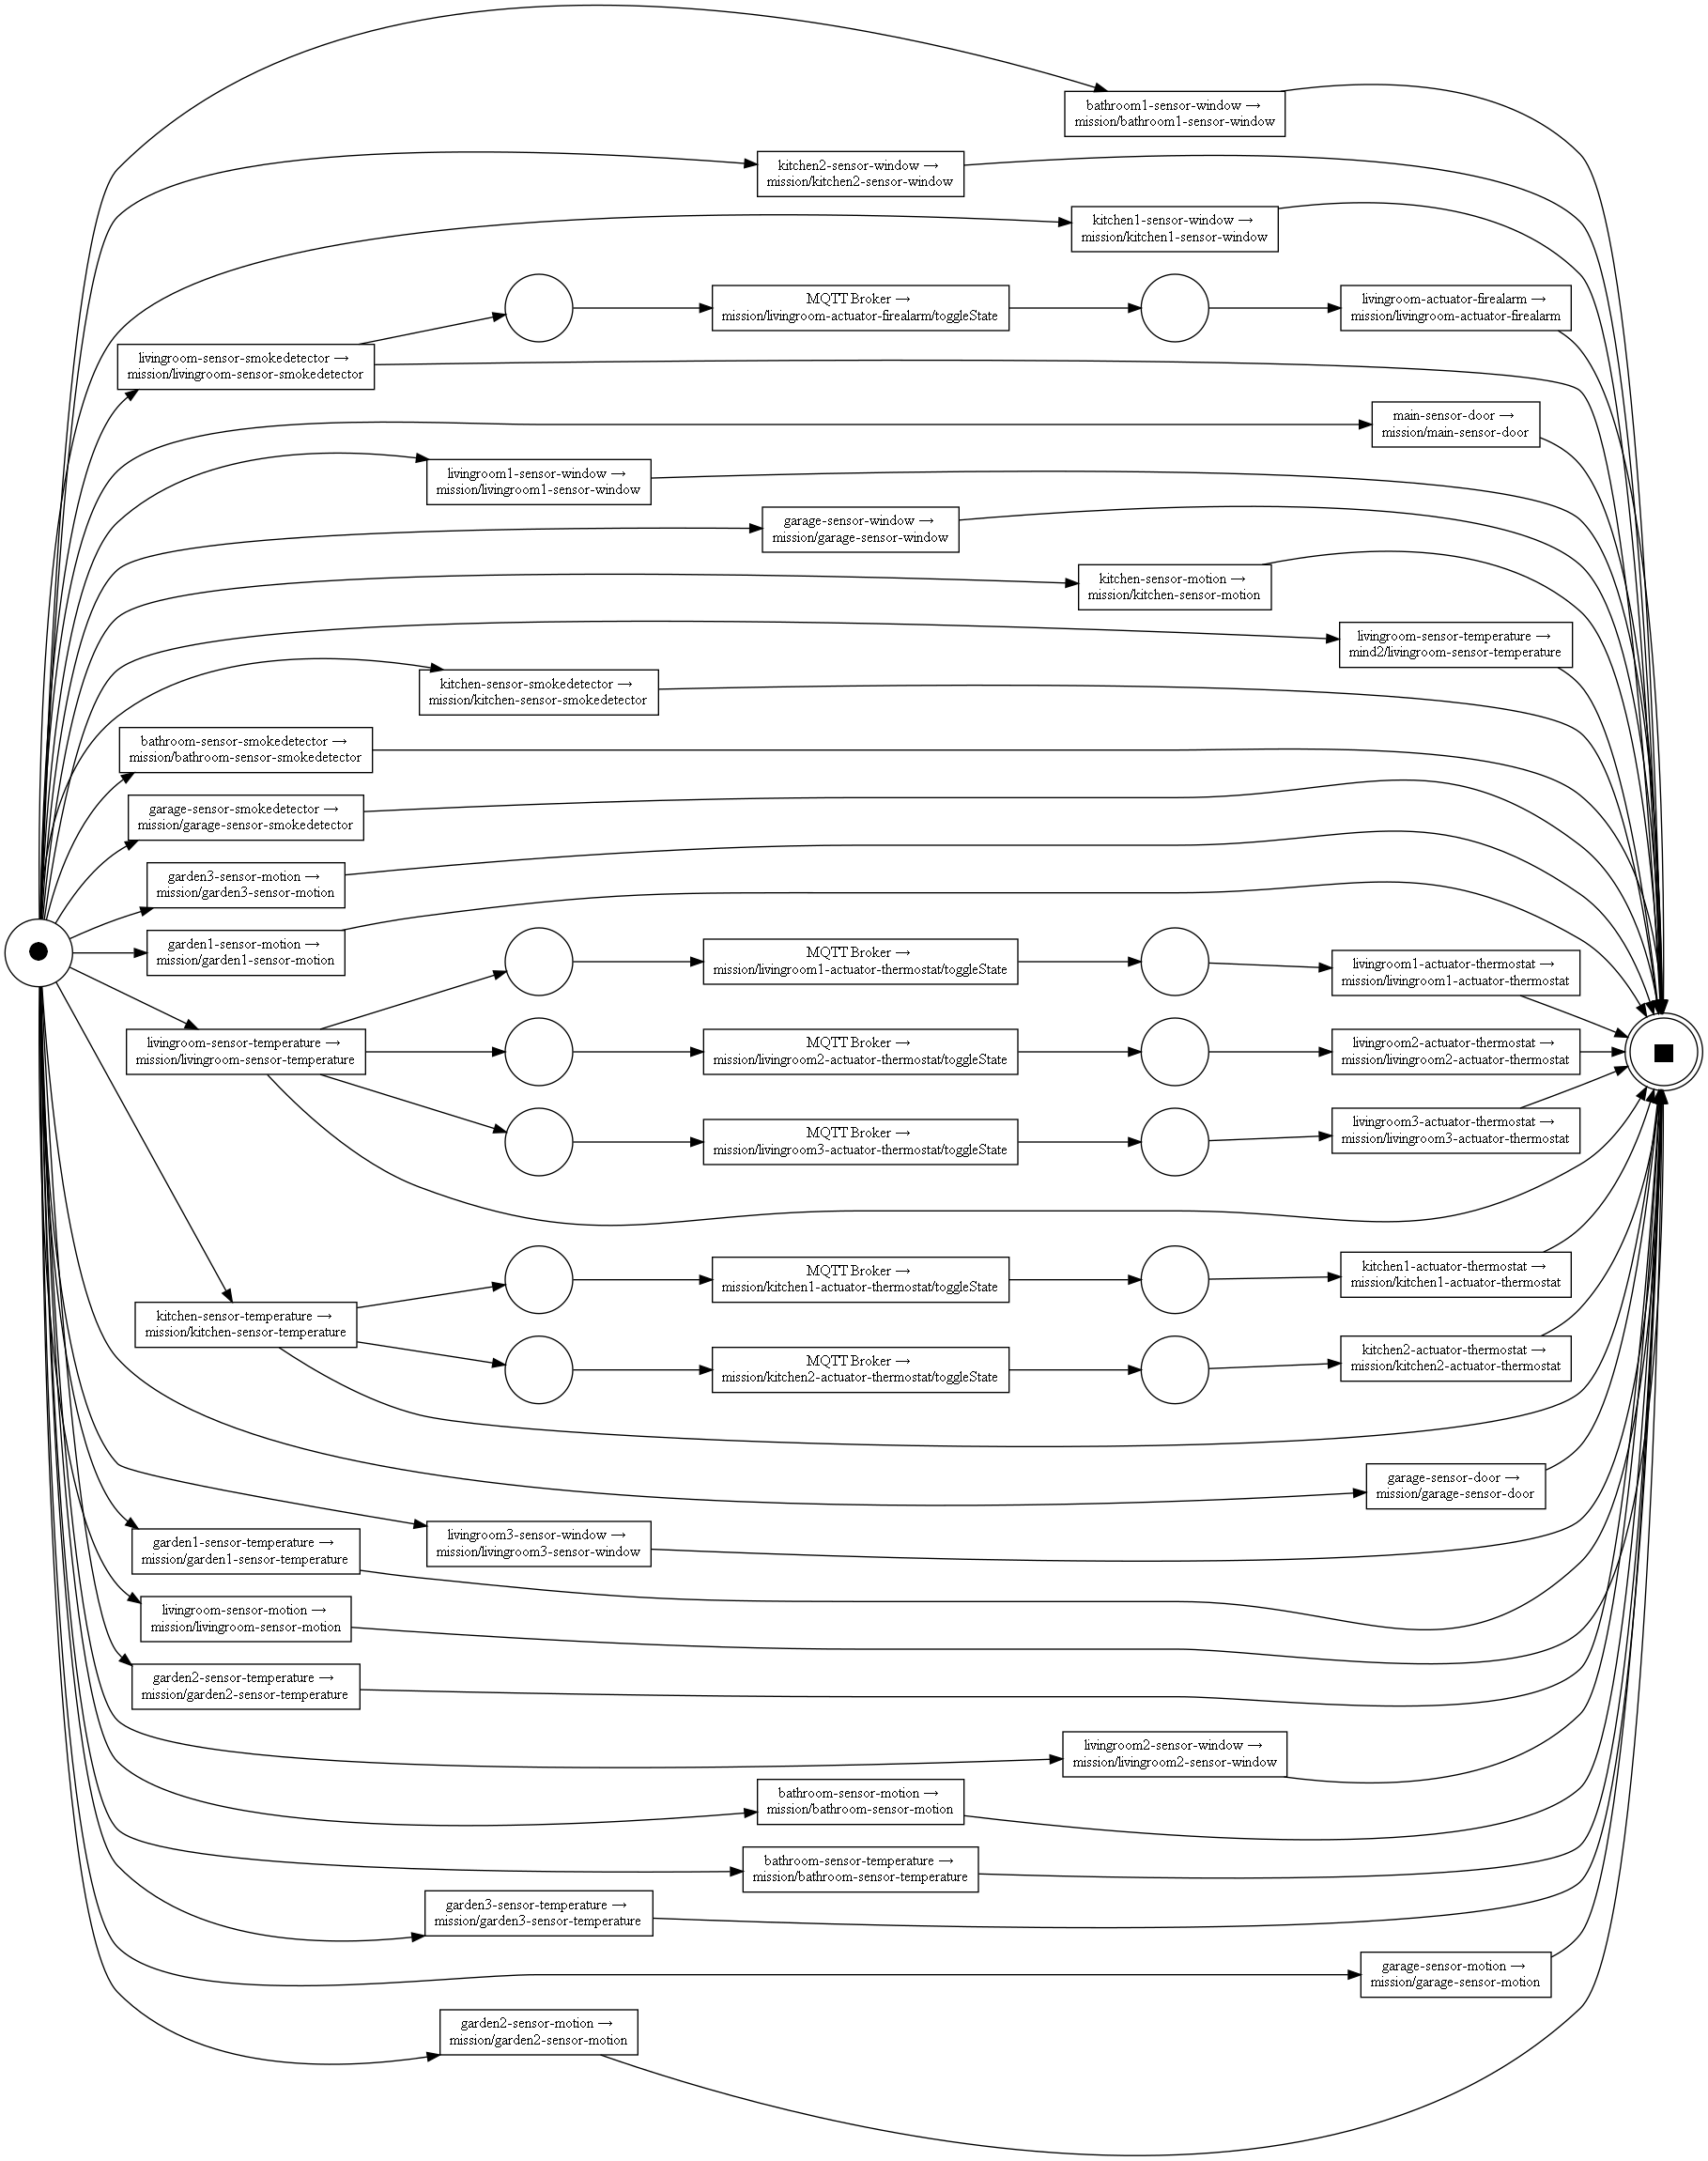

In [123]:
# Discover Petri net using the alpha miner algorithm
am_net, am_im, am_fm = pm4py.discover_petri_net_alpha(event_log)

# Generate the visualization of the Petri net
gviz = pm4py.visualization.petri_net.visualizer.apply(am_net, am_im, am_fm, log=event_log)

# Save the Petri net visualization as a PDF file
pn_visualizer.save(gviz, "alpha-miner.pdf")

# View the Petri net visualization
pm4py.visualization.petri_net.visualizer.view(gviz)

### (3.5) BPMN

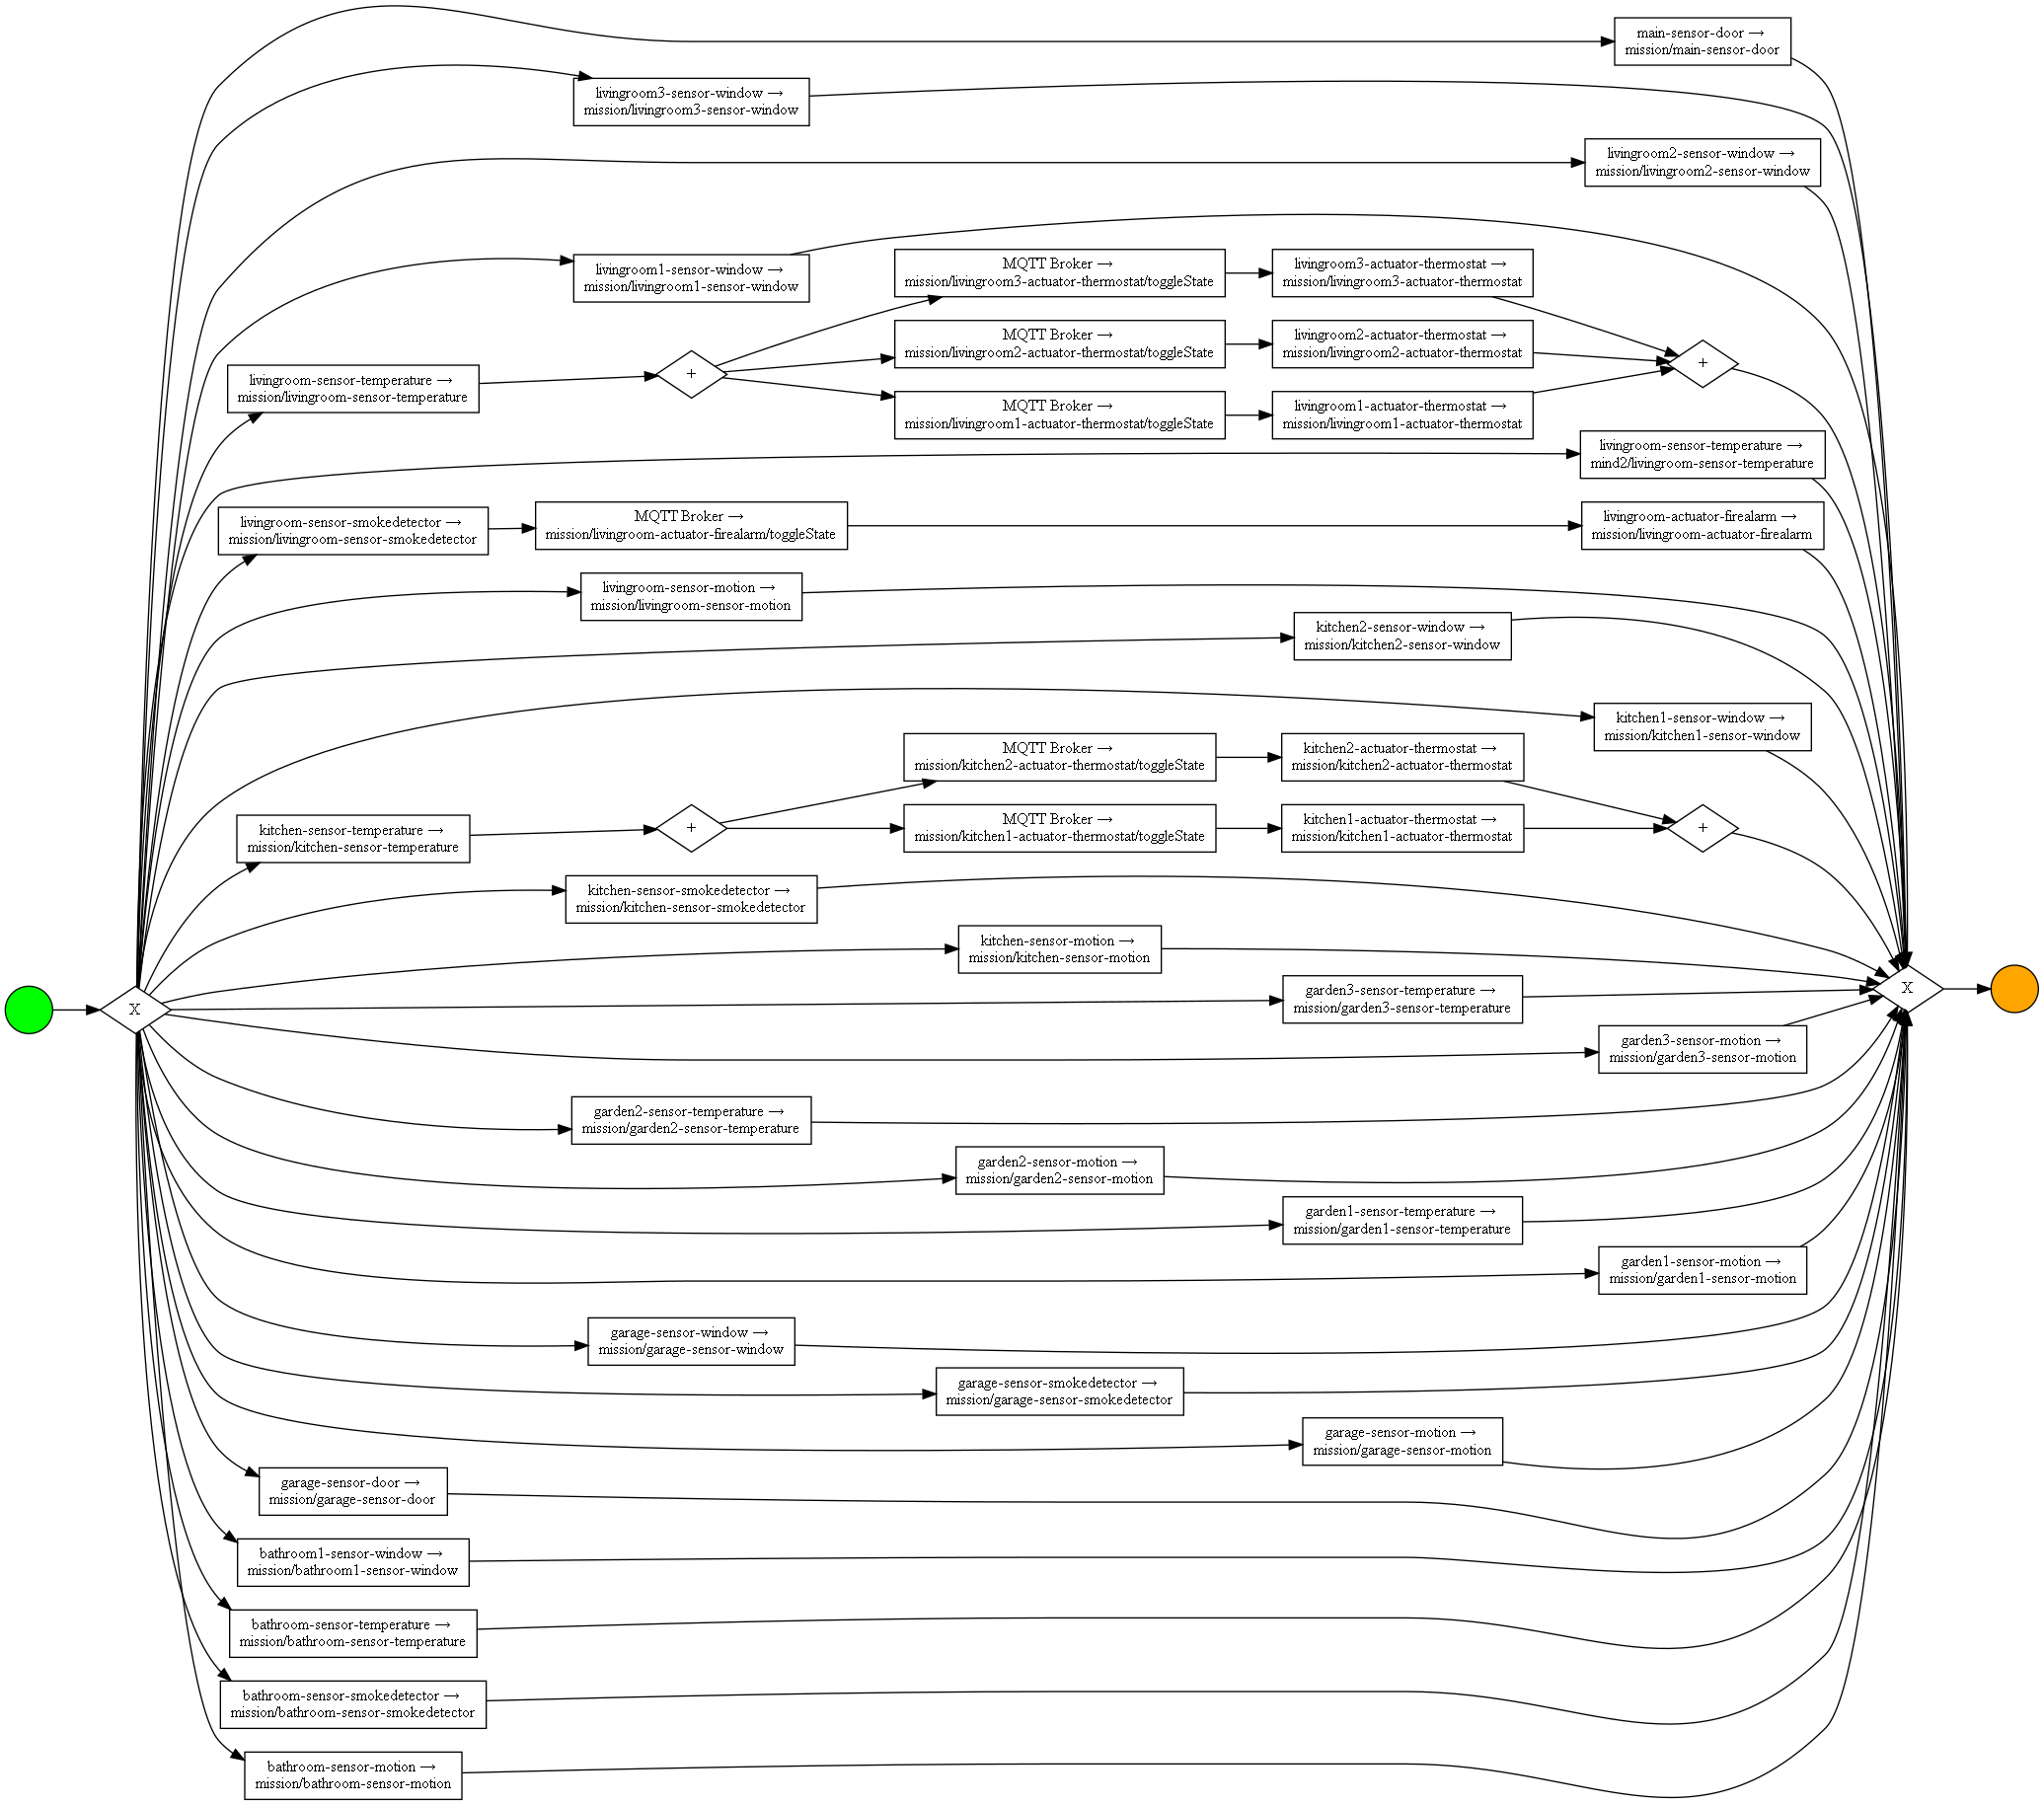

In [124]:
# Discover BPMN model using the inductive miner algorithm
bpmn_model = pm4py.discover_bpmn_inductive(df_event_log, noise_threshold=0.9)

# View the BPMN model
pm4py.view_bpmn(bpmn_model)

##  (4.0) Process Model Quality

In [125]:
data = []
language = variants_module.get_language(event_log)

def evaluate_petri_net(miner, log, net, im, fm):
    """
    Evaluate the quality criteria of a Petri net.
    """

    # Calculate fitness using token-based replay
    tbr_fitness = pm4py.fitness_token_based_replay(log, net, im, fm)
    fitness = round(tbr_fitness['perc_fit_traces'], 4)

    # Calculate precision using token-based replay
    etc_prec = pm4py.precision_token_based_replay(log, net, im, fm)
    precision = round(etc_prec * 100, 4)

    # Calculate generalization
    gen = generalization_evaluator.apply(log, net, im, fm)
    generalization = round(gen * 100, 4)

    # Calculate simplicity
    simp = simplicity_evaluator.apply(net)
    simplicity = round(simp * 100, 4)

    # Check soundness using Woflan algorithm
    soundness = woflan.apply(net, im, fm, parameters={woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: True,
                                                      woflan.Parameters.PRINT_DIAGNOSTICS: False,
                                                      woflan.Parameters.RETURN_DIAGNOSTICS: False})
    soundness = True if soundness == 1 else False

    # Print the evaluation results
    print(f"Fitness: {fitness}%")
    print(f"Precision: {precision}%")
    print(f"Generalization: {generalization}%")
    print(f"Simplicity: {simplicity}%")
    print(f"Soundness: {soundness}")

    # Store the evaluation results in the data list
    data.append((miner.title(), fitness, precision, generalization, simplicity, soundness))

###  (4.1) Inductive Miner


In [126]:
evaluate_petri_net("inductive miner", event_log, im_net, im_im, im_fm)

replaying log with TBR, completed variants ::   0%|          | 0/113 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/181 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/113 [00:00<?, ?it/s]

C:\Users\mail\anaconda3\lib\site-packages\pm4py\util\lp\variants\scipy_solver.py:26: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  sol = linprog(c, A_ub=Aub, b_ub=bub, A_eq=Aeq, b_eq=beq, method="revised simplex")


Fitness: 92.7302%
Precision: 99.9927%
Generalization: 93.8892%
Simplicity: 53.3333%
Soundness: True


### (4.2) Heuristic Miner

In [127]:
evaluate_petri_net("heuristic miner", event_log, hm_net, hm_im, hm_fm)

replaying log with TBR, completed variants ::   0%|          | 0/113 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/181 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/113 [00:00<?, ?it/s]

Fitness: 8.2662%
Precision: 99.9867%
Generalization: 95.636%
Simplicity: 69.5652%
Soundness: False


### (4.3) Alpha Miner

In [128]:
evaluate_petri_net("alpha miner", event_log, am_net, am_im, am_fm)

replaying log with TBR, completed variants ::   0%|          | 0/113 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/181 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/113 [00:00<?, ?it/s]

Fitness: 83.762%
Precision: 99.9927%
Generalization: 93.4878%
Simplicity: 46.087%
Soundness: False


### (4.4) Comparing the Miner


,Miner,Fitness,Precision,Generalization,Simplicity,Soundness
0,Inductive Miner,92.730200,99.992700,93.889200,53.333300,True
1,Heuristic Miner,8.266200,99.986700,95.636000,69.565200,False
2,Alpha Miner,83.762000,99.992700,93.487800,46.087000,False


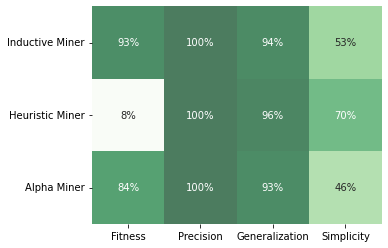

In [129]:
comparison = pd.DataFrame(data, columns=['Miner', 'Fitness', 'Precision', 'Generalization', 'Simplicity', 'Soundness'])
comparison[['Fitness', 'Precision', 'Generalization', 'Simplicity', 'Soundness']] = comparison[['Fitness', 'Precision', 'Generalization', 'Simplicity', 'Soundness']].apply(pd.to_numeric)

arr = (comparison[['Fitness', 'Precision', 'Generalization', 'Simplicity']]).to_numpy()
comparison = comparison.style.highlight_max(color = 'lightgreen', subset = ['Fitness', 'Precision', 'Generalization', 'Simplicity'], axis = 0)
display(comparison)
hmp = sns.heatmap(arr, annot=True, fmt='0.0f', cmap="Greens", alpha=0.7,  square=True, cbar=False, xticklabels=['Fitness', 'Precision', 'Generalization', 'Simplicity'], yticklabels=["Inductive Miner", "Heuristic Miner", "Alpha Miner"])
fig = hmp.get_figure()
for t in hmp.texts: t.set_text(t.get_text() + "%")
fig.savefig(f"resources/heatmap_flows_{len(event_log)}.svg")

### (4.5) Some Statistics of the Event Log

In [130]:
ll_case_durations = pm4py.get_all_case_durations(event_log)
case_arrival_ratio = pm4py.get_case_arrival_average(event_log)
case_dispersion_ratio = case_arrival.get_case_dispersion_avg(event_log, parameters={case_arrival.Parameters.TIMESTAMP_KEY: "time:timestamp"})
averaged_duration = round(sum(ll_case_durations)/len(ll_case_durations),5)
data = [(averaged_duration,round(case_arrival_ratio,5),round(case_dispersion_ratio,5))]
statistics = pd.DataFrame(data, columns=['Throughput Time  (sec.)', 'Case Arrival Ratio (sec.)', 'Case Dispersion Ratio  (sec.)'])
statistics

,Throughput Time (sec.),Case Arrival Ratio (sec.),Case Dispersion Ratio (sec.)
0,0.00185,0.3189,0.3189


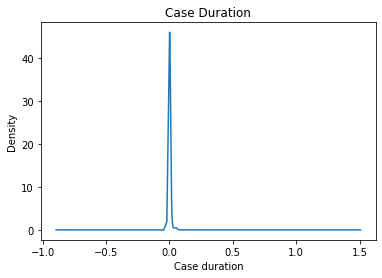

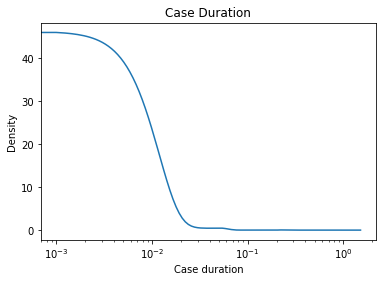

In [131]:
x, y = case_statistics.get_kde_caseduration(event_log, parameters={constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)
gviz = graphs_visualizer.apply_semilogx(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

#  (5.0) Attack Detection

In [132]:
def conformance_tbr(log, net, im, fm):
    """
    Performs token-based replay conformance checking and prints diagnostic information.
    """
    parameters_tbr = {
        token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: False,
        token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True
    }

    replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, net, im, fm, parameters=parameters_tbr)

    trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(log, trans_fitness)
    if len(trans_diagnostics) > 0:
        print("\n########################## TRANSITION DIAGNOSTICS ########################")
        for trans in trans_diagnostics:
            print(trans, trans_diagnostics[trans])

    print("\n########################## REPLAYED TRACES ##############################")
    for trace in replayed_traces:
        print(trace)

    act_diagnostics = duration_diagnostics.diagnose_from_notexisting_activities(log, unwanted_activities)
    if len(act_diagnostics) > 0:
        print("\n########################## Activity Diagnostics ###########################")
        for act in act_diagnostics:
            print(act)


def conformance_alignment(log, net, im, fm):
    """
    Performs alignment-based conformance checking and prints the fitness score for each trace.
    """
    parameters = {
        "pm4py:param:activity_key": "concept:name",
        "pm4py:param:resource_key": "org:resource"
    }

    aligned_traces = alignments.apply_log(log, net, im, fm, parameters=parameters)

    for case in aligned_traces:
        print(case)


def conformance_log_skeleton(log):
    """
    Performs log skeleton-based conformance checking and prints anomalies if found.
    """
    skeleton = lsk_discovery.apply(log, parameters={
        lsk_discovery.Variants.CLASSIC.value.Parameters.NOISE_THRESHOLD: 0.0
    })
    conf_result = lsk_conformance.apply(log, skeleton)

    if any(not dev["is_fit"] for dev in conf_result):
        print("Anomalies:")
        for dev in conf_result:
            if not dev["is_fit"]:
                print(dev)
    else:
        print("No anomalies")

        

## (5.1) Scenario 1: DoS attack with the same correlation identifier or different ones

### (5.1.1) Load malicious data sample and preprocess it

In [133]:
df_flows_malicious_dos = pd.read_csv(filename_malicious_DoS, delimiter=";")
df_flows_malicious_dos = preprocessing(df_flows_malicious_dos)
event_log_malicious_dos, df_flows_malicious_dos = event_log_conversion(df_flows_malicious_dos)
df_flows_malicious_dos.head()

,time:timestamp,case:concept:name,org:resource,concept:name
0,2022-09-21 15:26:40.114727,1,livingroom-temperature-sensor,livingroom-temperature-sensor → \nmission/gard...
1,2022-09-21 15:26:41.114727,2,livingroom-temperature-sensor,livingroom-temperature-sensor → \nmission/gard...
2,2022-09-21 15:26:43.114727,3,livingroom-temperature-sensor,livingroom-temperature-sensor → \nmission/gard...
3,2022-09-21 15:26:44.114727,4,livingroom-temperature-sensor,livingroom-temperature-sensor → \nmission/gard...
4,2022-09-21 15:26:45.114727,5,livingroom-temperature-sensor,livingroom-temperature-sensor → \nmission/gard...


### (5.1.2) Procedural conformance checking

### (5.1.2.1) Token-based replay

In [134]:
conformance_tbr(event_log_malicious_dos, am_net, am_im, am_fm)

replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]


########################## REPLAYED TRACES ##############################
{'trace_is_fit': False, 'trace_fitness': 0.0, 'activated_transitions': [], 'reached_marking': ['start:1'], 'enabled_transitions_in_marking': {(bathroom-sensor-smokedetector → 
mission/bathroom-sensor-smokedetector, 'bathroom-sensor-smokedetector → 
mission/bathroom-sensor-smokedetector'), (kitchen-sensor-smokedetector → 
mission/kitchen-sensor-smokedetector, 'kitchen-sensor-smokedetector → 
mission/kitchen-sensor-smokedetector'), (livingroom-sensor-temperature → 
mind2/livingroom-sensor-temperature, 'livingroom-sensor-temperature → 
mind2/livingroom-sensor-temperature'), (livingroom3-sensor-window → 
mission/livingroom3-sensor-window, 'livingroom3-sensor-window → 
mission/livingroom3-sensor-window'), (kitchen1-sensor-window → 
mission/kitchen1-sensor-window, 'kitchen1-sensor-window → 
mission/kitchen1-sensor-window'), (kitchen2-sensor-window → 
mission/kitchen2-sensor-window, 'kitchen2-sensor-window → 
mission/k

### (5.1.2.2) Alignments

In [135]:
conformance_alignment(event_log_malicious_dos, am_net, am_im, am_fm)

aligning log, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

{'alignment': [('>>', 'main-sensor-door → \nmission/main-sensor-door'), ('livingroom-temperature-sensor → \nmission/garden2-sensor-motion', '>>')], 'cost': 20000, 'visited_states': 2, 'queued_states': 29, 'traversed_arcs': 29, 'lp_solved': 1, 'fitness': 0.0, 'bwc': 20000}
{'alignment': [('>>', 'main-sensor-door → \nmission/main-sensor-door'), ('livingroom-temperature-sensor → \nmission/garden2-sensor-motion', '>>')], 'cost': 20000, 'visited_states': 2, 'queued_states': 29, 'traversed_arcs': 29, 'lp_solved': 1, 'fitness': 0.0, 'bwc': 20000}
{'alignment': [('>>', 'main-sensor-door → \nmission/main-sensor-door'), ('livingroom-temperature-sensor → \nmission/garden2-sensor-motion', '>>')], 'cost': 20000, 'visited_states': 2, 'queued_states': 29, 'traversed_arcs': 29, 'lp_solved': 1, 'fitness': 0.0, 'bwc': 20000}
{'alignment': [('>>', 'main-sensor-door → \nmission/main-sensor-door'), ('livingroom-temperature-sensor → \nmission/garden2-sensor-motion', '>>')], 'cost': 20000, 'visited_states': 

## (5.1.3) Declarative conformance checking

### (5.1.3.1) Log skeleton

In [136]:
conformance_log_skeleton(event_log_malicious_dos)

Anomalies:
{'deviations': [('always_after', (('livingroom-temperature-sensor → \nmission/garden2-sensor-motion', 'livingroom-temperature-sensor → \nmission/garden2-sensor-motion'),)), ('always_before', (('livingroom-temperature-sensor → \nmission/garden2-sensor-motion', 'livingroom-temperature-sensor → \nmission/garden2-sensor-motion'),))], 'no_dev_total': 2, 'no_constr_total': 3, 'dev_fitness': 0.33333333333333337, 'is_fit': False}
{'deviations': [('always_after', (('livingroom-temperature-sensor → \nmission/garden2-sensor-motion', 'livingroom-temperature-sensor → \nmission/garden2-sensor-motion'),)), ('always_before', (('livingroom-temperature-sensor → \nmission/garden2-sensor-motion', 'livingroom-temperature-sensor → \nmission/garden2-sensor-motion'),))], 'no_dev_total': 2, 'no_constr_total': 3, 'dev_fitness': 0.33333333333333337, 'is_fit': False}
{'deviations': [('always_after', (('livingroom-temperature-sensor → \nmission/garden2-sensor-motion', 'livingroom-temperature-sensor → \n

## (5.2) Scenario 2: Sidechannel attack with different correlation identifier

### (5.2.1) Load malicious data sample and preprocess it

In [137]:
df_flows_malicious_sidechannel = pd.read_csv(filename_malicious_sidechannel, delimiter=";")
df_flows_malicious_sidechannel = preprocessing(df_flows_malicious_sidechannel)
event_log_malicious_sidechannel, df_flows_malicious_sidechannel = event_log_conversion(df_flows_malicious_sidechannel)
df_flows_malicious_sidechannel.head()

,time:timestamp,case:concept:name,org:resource,concept:name
0,2022-09-21 15:26:39.420099,1,MQTT Broker,MQTT Broker → \nmission/kitchen-sensor-tempera...
1,2022-09-21 15:26:39.420099,1,MQTT Broker,MQTT Broker → \nmission/kitchen-sensor-tempera...
2,2022-09-21 15:26:39.420099,1,MQTT Broker,MQTT Broker → \nmission/kitchen-sensor-tempera...
3,2022-09-21 15:26:39.420099,1,MQTT Broker,MQTT Broker → \nmission/kitchen-sensor-tempera...
4,2022-09-21 15:26:39.420099,1,MQTT Broker,MQTT Broker → \nmission/kitchen-sensor-tempera...


### (5.2.2) Procedural conformance checking

### (5.2.2.1) Token-based replay

In [138]:
conformance_tbr(event_log_malicious_sidechannel, am_net, am_im, am_fm)


########################## REPLAYED TRACES ##############################
{'trace_is_fit': False, 'trace_fitness': 0.0, 'activated_transitions': [], 'reached_marking': ['start:1'], 'enabled_transitions_in_marking': {(bathroom-sensor-smokedetector → 
mission/bathroom-sensor-smokedetector, 'bathroom-sensor-smokedetector → 
mission/bathroom-sensor-smokedetector'), (kitchen-sensor-smokedetector → 
mission/kitchen-sensor-smokedetector, 'kitchen-sensor-smokedetector → 
mission/kitchen-sensor-smokedetector'), (livingroom-sensor-temperature → 
mind2/livingroom-sensor-temperature, 'livingroom-sensor-temperature → 
mind2/livingroom-sensor-temperature'), (livingroom3-sensor-window → 
mission/livingroom3-sensor-window, 'livingroom3-sensor-window → 
mission/livingroom3-sensor-window'), (kitchen1-sensor-window → 
mission/kitchen1-sensor-window, 'kitchen1-sensor-window → 
mission/kitchen1-sensor-window'), (kitchen2-sensor-window → 
mission/kitchen2-sensor-window, 'kitchen2-sensor-window → 
mission/k

### (5.1.2.2) Alignments

In [139]:
conformance_alignment(event_log_malicious_sidechannel, am_net, am_im, am_fm)

{'alignment': [('MQTT Broker → \nmission/kitchen-sensor-temperature', '>>'), ('MQTT Broker → \nmission/kitchen-sensor-temperature', '>>'), ('MQTT Broker → \nmission/kitchen-sensor-temperature', '>>'), ('MQTT Broker → \nmission/kitchen-sensor-temperature', '>>'), ('MQTT Broker → \nmission/kitchen-sensor-temperature', '>>'), ('>>', 'main-sensor-door → \nmission/main-sensor-door')], 'cost': 60000, 'visited_states': 6, 'queued_states': 167, 'traversed_arcs': 167, 'lp_solved': 1, 'fitness': 0.0, 'bwc': 60000}


## (5.1.3) Declarative conformance checking

### (5.1.3.1) Log skeleton

In [140]:
conformance_log_skeleton(event_log_malicious_sidechannel)

No anomalies
